# pharmapsychotic's modified ruDALLE

This builds on [Alex Shonenkov](https://www.kaggle.com/shonenkov)'s [ruDALLE aspect ratio notebook](https://colab.research.google.com/drive/124zC1w2qHR1ijfEPQVvLccLRBLD_3duG) 

2022/05/20:
* You can now pick between Malovich and Surrealist and other ruDALLe models
* Translations to Russian are done remotely through Google Translate by default but now have option to download and use Facebook's English to Russian translation Ai model locally.

2022/05/18:
* Google Drive integration. All images and settings are saved to your Drive/AI/rudalle folder.
* Batch runs. Let it generate hundreds of images for you while you eat some tacos and watch Youtube.
* Automatic translation to Russian.

If you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


# 1. Set Up

In [ ]:
#@title 1.1 Check GPU
!nvidia-smi -L

In [ ]:
#@title 1.2 Mount Google Drive and Prepare Folders
from google.colab import drive
drive.mount('/content/gdrive')
outputs_path = "/content/gdrive/MyDrive/AI/rudalle"
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")

In [ ]:
#@title 1.3 Install libraries
translation_system = 'Google Translate' #@param ['Google Translate','Facebook FSMT']

if translation_system == 'Facebook FSMT':
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4 --quiet
!pip3 install translatepy --quiet
!pip3 install rudalle==1.0.0 --quiet
!git clone https://github.com/shonenkov-AI/rudalle-aspect-ratio.git

import json
import os
import random
from glob import glob
batch_idx = len(glob(outputs_path+"/*.txt"))

In [ ]:
#@title 1.4 Load models
#@markdown - Malevich - normal model
#@markdown - Malevich_v2 - old version of Malevich
#@markdown - Surrealist XL - fine-tuned for surreal art style
#@markdown - Emojich - cartoon emoji style
#@markdown - Kandinsky - 10X bigger model, might work if you get an A100
rudalle_model = 'Surrealist_XL' #@param ['Malevich', 'Surrealist_XL', 'Emojich', 'Malevich_v2', 'Kandinsky']  

import sys
sys.path.insert(0, './rudalle-aspect-ratio')
from rudalle_aspect_ratio import RuDalleAspectRatio, get_rudalle_model
from rudalle import get_vae, get_tokenizer
from rudalle.pipelines import show
device = 'cuda'
dalle = get_rudalle_model(rudalle_model, fp16=True, device=device)
vae, tokenizer = get_vae().to(device), get_tokenizer()

from translatepy import Translator, Language
ts = Translator()
tmodel = None
if translation_system == 'Facebook FSMT':
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
    tmodel = AutoModelForSeq2SeqLM.from_pretrained("facebook/wmt19-en-ru").to(device="cuda:0")
    ttokenizer = AutoTokenizer.from_pretrained("facebook/wmt19-en-ru")


# 2. Generate Images

Using seed: 3329285387
Translated prompt to: масляная живопись дружелюбного волка


  0%|          | 0/48 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:89: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim
100%|██████████| 48/48 [01:15<00:00,  1.56s/it]


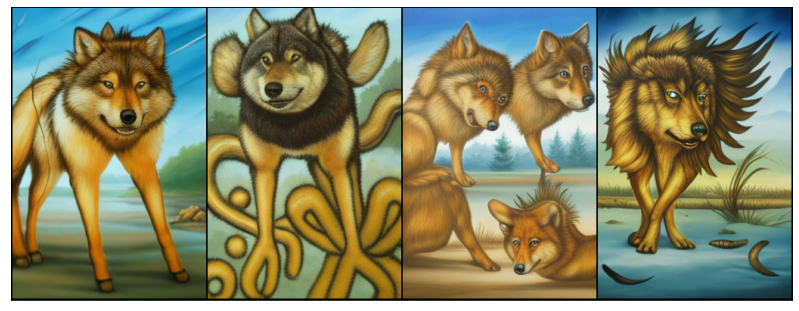

In [5]:
#@markdown Results saved to Google Drive/AI/rudalle

#@markdown You can crank up images_per_batch based on how much GPU RAM is available.

#@markdown Increase num_batches to generate lots of images while you go do other stuff then come back later to cherry pick your favorites from your Google Drive.

#@markdown Leave seed at -1 to get a different random seed each run automatically

#@markdown For an explanation of top_k and top_p check out ai_curio's [twitter thread](https://twitter.com/ai_curio/status/1516575090837762053?s=20&t=DU4lS9S4UClnlOhCGLMnRA)

#@markdown ---

prompt = "oil painting of a friendly wolf" #@param {type:"string"}
aspect_ratio = "2:3" #@param {type: "string"}
images_per_batch = 4#@param {type: "integer"}
num_batches = 1#@param {type: "integer"}
seed = -1#@param {type: "integer"}
top_k = 128 #@param {type:"slider", min:128, max:4096, step:128}
top_p = 0.9 #@param {type:"slider", min:0.5, max:1, step:0.005}

if seed == -1:
    seed = random.randint(0, 2**32)
    print(f"Using seed: {seed}")

# save settings
settings = {
    'prompt': prompt,
    'aspect_ratio': aspect_ratio,
    'images_per_batch': images_per_batch,
    'num_batches': num_batches,
    'seed': seed,
    'top_k': top_k,
    'top_p': top_p
}
while os.path.isfile(f"{outputs_path}/{batch_idx}_settings.txt"):
    batch_idx += 1
with open(f"{outputs_path}/{batch_idx:04d}_settings.txt", "w+") as f:
    json.dump(settings, f, ensure_ascii=False, indent=4)

# translate prompt to Russian if it isn't already Russian
input_lang = ts.language(prompt).result.alpha2
if input_lang != 'ru':
    if tmodel != None:
        print(f"Translating using Facebook FSMT...")
        input_ids = ttokenizer.encode(prompt, return_tensors="pt").to(device="cuda:0")
        outputs = tmodel.generate(input_ids)
        prompt = ttokenizer.decode(outputs[0], skip_special_tokens=True)
    else:
        prompt = ts.translate(prompt, "ru").result
    print(f"Translated prompt to: {prompt}")

a, b = aspect_ratio.split(":")
aspect_ratio = int(a)/int(b)

image_idx = 0
for i in range(num_batches):
    rudalle_ar = RuDalleAspectRatio(
        dalle=dalle, vae=vae, tokenizer=tokenizer,
        aspect_ratio=aspect_ratio, bs=4, device=device
    )
    _, result_pil_images = rudalle_ar.generate_images(prompt, top_k, top_p, images_per_batch, seed=seed)
    show(result_pil_images, 1 if aspect_ratio > 1 else 4)

    for img in result_pil_images:
        img.save(f"{outputs_path}/{batch_idx:04d}_{image_idx:04d}.png")
        image_idx += 1
    seed += 1
